In [16]:
# install libraries
!pip install scikit-learn transformers opencv-python matplotlib torch pillow
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-vxx9zh5q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-vxx9zh5q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


## Import libraries and modules

In [82]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import cv2
import torch
from transformers import AutoImageProcessor, ResNetModel
import clip
from PIL import Image

## Dataset Analysis

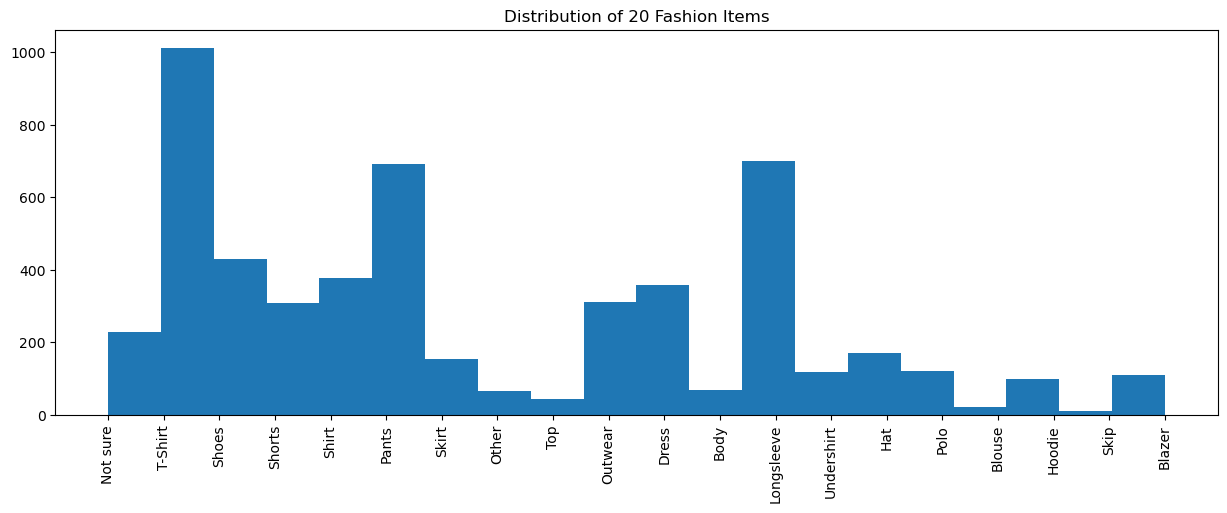

In [83]:
# load the dataset
data = pd.read_csv('images.csv')

# analysis
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

# visualize the different categories of fashion items
plt.figure(figsize=(15, 5))
plt.title("Distribution of {} Fashion Items".format(len(unique_items)))
plt.hist(labels, bins=len(unique_items))
plt.xticks(rotation=90)
plt.show()

## Data cleansing

In [84]:
# remove the records with the label Skip, because the images with skip labels are not present in the images folder or occluded
data = data[data['label'] != 'Skip']
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

## Load the ResNet-50 model for image features extraction

In [85]:
# load the resnet model for image features extraction
model_name = "microsoft/resnet-50"
resnet_img_processor = AutoImageProcessor.from_pretrained(model_name)
resnet_model = ResNetModel.from_pretrained(model_name)

## Load the clip model for extracting image and text query feature embeddings

In [86]:
clip_model, clip_preprocess = clip.load("ViT-B/32", "cpu")

## Helper functions

In [89]:
def extract_image_features(img_path):
  # load and preprocess the image for the ResNet model
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # resize the image to 224x224 to be compatible with ResNet model input size
  image = cv2.resize(image, (224, 224))
  # convert the image to PyTorch tensor and change dimensions to CxHxW as expected by the ResNet model
  image = torch.tensor(image).permute(2, 0, 1).float()
  inputs = resnet_img_processor(images=[image], return_tensors="pt")

  # forward pass to get features without the final classification layer
  with torch.no_grad():
    outputs = resnet_model(**inputs)

  # use the last convolutional layer output as feature vector
  # it is a 2048-dimensional vector
  feature_vector = outputs.pooler_output.squeeze()

  return feature_vector


def extract_image_semantic_features(img_path):
  image = Image.open(img_path)
  # preprocess the image for the CLIP model
  image = clip_preprocess(image).unsqueeze(0).to("cpu")
  # disable gradient calculation
  with torch.no_grad():
    # get the image embedding
    image_features = clip_model.encode_image(image)
    # normalize the image embeddings to be between 0 and 1
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
  return image_features.cpu().numpy().squeeze()


def encode_text_query(query):
  text = clip.tokenize([query]).to("cpu")
  with torch.no_grad():
    text_features = clip_model.encode_text(text)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
  return text_features.cpu().numpy().squeeze()

# returns the indices of the most similar images to the test image
def get_recommendations(test_img_path, count=5, query=""):
  # get feature vector for the test image
  test_img_features = extract_image_features(test_img_path)
  # calculate similarity scores between the test image and all the images in the dataset
  similarity_scores = cosine_similarity([test_img_features], feature_vectors_matrix).flatten()
  # make sure the test image is not returned as recommended
  similarity_scores = np.where(similarity_scores == 1.0, 0, similarity_scores)


  # filter by query if supplied
  if query:
    query_features = encode_text_query(query)
    # calculate similarity scores between the text query and all the images in the dataset
    text_similarities = cosine_similarity([query_features], semantic_feature_vectors_matrix).flatten()
    # combine the similarity scores from image and text, giving more weight to query similarity scores to filter results
    similarity_scores = 0.2 * similarity_scores + 0.8 * text_similarities

  # sort the similarity scores in descending order, meaning similar items will show up first
  similar_indices = np.argsort(similarity_scores)[::-1]
  return similar_indices[:count]

def get_and_display_recommendations(test_img_path, recommendations_count=5, query=""):
  # load the test image
  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  # get the recommended images against the test image
  recommended_img_indexes = get_recommendations(test_img_path, recommendations_count, query)
  recommended_images = [(cv2.imread(os.path.join("images", image_ids[idx] + ".jpg"))) for idx in
                        recommended_img_indexes]

  subplots_count = recommendations_count + 1
  # plot the test image
  plt.figure(figsize=(15, 5))
  plt.subplot(1, subplots_count, 1)
  plt.imshow(test_img)
  plt.title("Test")
  plt.axis('off')

  # plot the recommended images
  for i, img in enumerate(recommended_images):
    plt.subplot(1, subplots_count, i + 2)
    # convert the image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Recommended " + str(i + 1))
    plt.axis('off')


plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Extract features for all the images in the dataset

In [ ]:
# extract Resnet50 features for the images in the dataset
feature_vectors = [extract_image_features(os.path.join("images", img_id + ".jpg")) for img_id in image_ids]

In [ ]:
# extract CLIP features for the images in the dataset
semantic_feature_vectors = [extract_image_semantic_features(os.path.join("images", img_id + ".jpg")) for img_id in image_ids]

In [ ]:
# Resnet feature vectors
print("ResNet feature vectors for all the {} images".format(len(feature_vectors)))
print("Feature Shape", feature_vectors[0].shape)

# CLIP feature vectors
print("CLIP feature vectors for all the {} images".format(len(semantic_feature_vectors)))
print("Feature Shape", semantic_feature_vectors[0].shape)

In [ ]:
# calculate cosine similarity between the feature vectors
feature_vectors_matrix = np.stack(feature_vectors)
semantic_feature_vectors_matrix = np.stack(semantic_feature_vectors)
# save the feature matrices to a file
np.save("embeddings/resnet_feature_matrix.npy", feature_vectors_matrix)
np.save("embeddings/clip_feature_matrix.npy", semantic_feature_vectors_matrix)
print(feature_vectors_matrix.shape)
print(semantic_feature_vectors_matrix.shape)

## Load the features matrix

In [90]:
# load the feature matrix
feature_vectors_matrix = np.load("embeddings/resnet_feature_matrix.npy")
semantic_feature_vectors_matrix = np.load("embeddings/clip_feature_matrix.npy")

## Test the recommendation system

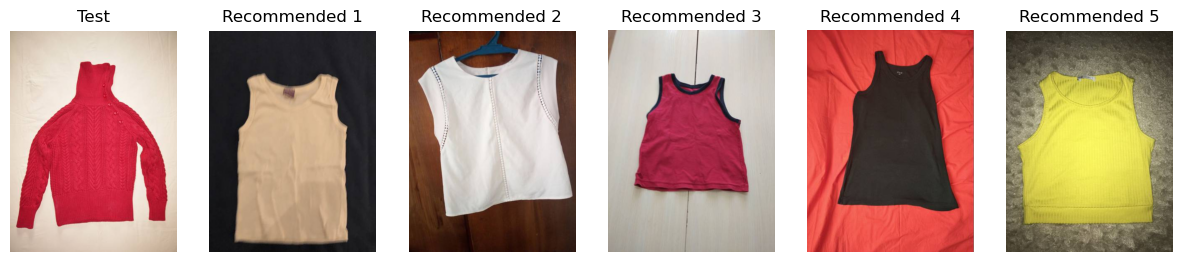

In [94]:
test_img_path = os.path.join("images", "0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg")
# further filtering e.g. sleeveless, grey, white, puffer, women jackets
get_and_display_recommendations(test_img_path, recommendations_count=5, query="sleeveless")

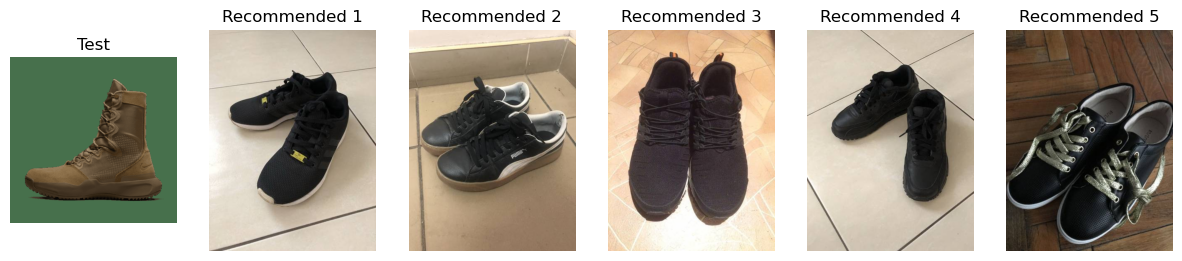

In [96]:
test_img_path = os.path.join("test_images", "2.png")
# further filtering e.g. white, black, grey
get_and_display_recommendations(test_img_path, recommendations_count = 5, query="black")

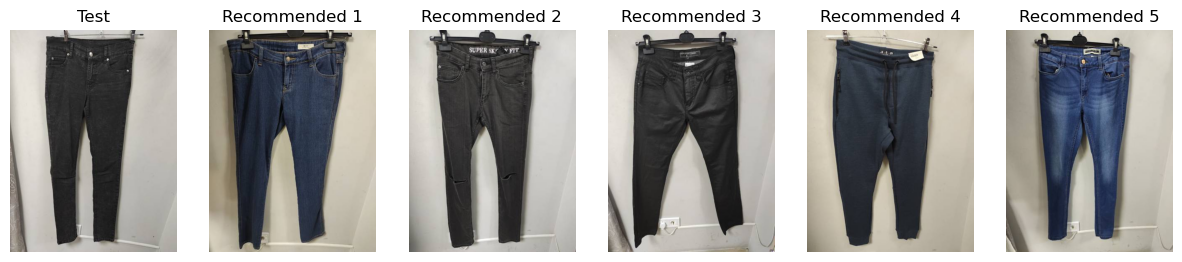

In [68]:
test_img_path = os.path.join("images", "1a08f33a-2ff4-4fb8-920b-8ff514bcdda8.jpg")
# further blue, black
get_and_display_recommendations(test_img_path, recommendations_count = 5)